In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split


# Reading Files

In [43]:
df = pd.read_csv('../../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)

# Model Fitting

### Step 1: data preparation

In [44]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable

# Split data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Step 2: Pipeline with Feature Selection and Hyperparameter Tuning for SVM Using GridSearchCV

In [45]:
# Use LinearSVC for RFE
svm = LinearSVC(max_iter=5000)

# Define a pipeline with standardization and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('feature_selection', RFE(estimator=svm)),  # RFE for feature selection
    ('svm', svm)  # LinearSVC model
])

# Define the hyperparameter search space, including n_features_to_select
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15, 20,25],  # Try different numbers of features
    'svm__C': [0.1, 1, 10, 100]  # Regularization parameter for LinearSVC
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'feature_selection__n_features_to_select': 20, 'svm__C': 0.1}


### Step 3: Evaluate model performance on a test set

In [46]:
# Use the best model with optimal parameters to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8714
Precision: 0.8132
Recall: 0.6218
F1 Score: 0.7048


### Step 5: Plot the ROC curve

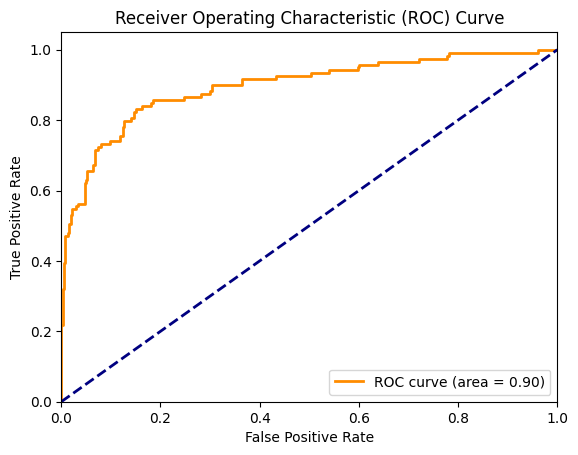

In [48]:
# Get the predicted probability scores (decision function) from the model
y_score = grid_search.best_estimator_.decision_function(X_test)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Handling Imbalanced Data with Balanced Class Weights in SVM

In [49]:
print(y.value_counts())

Cardiovascular
0.0    1206
1.0     398
Name: count, dtype: int64


From the output it can be seen that the y data is unbalanced. There are 1206 samples with a category of 0.0, while there are only 398 samples with a category of 1.0. Typically, when there is a large difference in the number of samples between categories, the model may be biased towards predicting the category with the larger number during training.

In [50]:
# Use LinearSVC for RFE with class_weight='balanced'
svm = LinearSVC(max_iter=5000, class_weight='balanced')

# Define a pipeline with standardization and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('feature_selection', RFE(estimator=svm)),  # RFE for feature selection
    ('svm', svm)  # LinearSVC model with class_weight='balanced'
])

# Define the hyperparameter search space, including n_features_to_select
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15, 20, 25],  # Try different numbers of features
    'svm__C': [0.1, 1, 10, 100]  # Regularization parameter for LinearSVC
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Best Parameters:  {'feature_selection__n_features_to_select': 25, 'svm__C': 10}
Accuracy: 0.8361
Precision: 0.6266
Recall: 0.8319
F1 Score: 0.7148


After using `class_weight='balanced'`, the SVM's Recall increased from 0.6218 to 0.7143, indicating an improvement in the model's ability to identify positive samples (i.e., the minority class). However, Precision dropped from 0.9024 to 0.7025, which means the accuracy of the model's predictions decreased. Overall, this method prioritizes reducing missed positive samples but at the cost of some precision.

#### Handling Imbalanced Data Using SMOTE in SVM

Best Parameters:  {'feature_selection__n_features_to_select': 15, 'svm__C': 0.1}
Accuracy: 0.8340
Precision: 0.6612
Recall: 0.6723
F1 Score: 0.6667


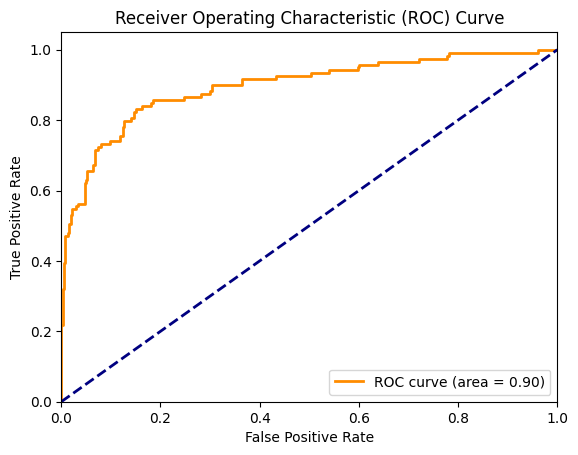

In [51]:
# Apply SMOTE to balance the training set
smote = SMOTE(sampling_strategy=0.6, random_state=42)

# Oversample the training data using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Use LinearSVC for RFE (no class_weight='balanced')
svm = LinearSVC(max_iter=5000)

# Define a pipeline with standardization and RFE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('feature_selection', RFE(estimator=svm)),  # RFE for feature selection
    ('svm', svm)  # LinearSVC model
])

# Define the hyperparameter search space, including n_features_to_select
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15, 20, 25],  # Try different numbers of features
    'svm__C': [0.1, 1, 10, 100]  # Regularization parameter for LinearSVC
}

# Perform a grid search with 20-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter search on the SMOTE-processed training set
grid_search.fit(X_train_smote, y_train_smote)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The original SVM had the highest precision but lower recall. Using `class_weight='balanced'` improved recall but reduced precision and accuracy. SMOTE provided the best balance, improving recall while maintaining good precision and accuracy, making it the most effective approach.